## Setup and Data Loading

First, let's install the necessary libraries.

In [ ]:
!pip install langdetect
!pip install deep_translator
!pip install nltk
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=0012ecc760abbace1274209a4de5884b91796e71610caf68def6cb316a0b662d
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00


Importing required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Downloading 'nltk' libraries

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Changing directory to My Drive/Internship

In [ ]:
%cd /content/drive/My\ Drive/Internship

/content/drive/My Drive/Internship


Loading the data

In [ ]:
df = pd.read_csv('full_data.csv')

Displaying the first few rows and basic information about the dataset

In [ ]:
print(df.head())
print(df.info())

                                               title custom_audience_persona  \
0                   VP Digital Transformation DevOps           Data Engineer   
1                             Senior Patent Attorney           Unprioritized   
2         Assistant Professor, School of Engineering           Data Engineer   
3  Engineering Director, Software Products, Elect...           Data Engineer   
4                 MS Data Science Graduating Student          Data Scientist   

  custom_cdo_cio_cto  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034452 entries, 0 to 2034451
Data columns (total 3 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   title                    object
 1   custom_audience_persona  object
 2   custom_cdo_cio_cto       object
dtypes: object(3)
memory usage: 46.6+ MB
None


Checking the distribution of labeled vs unlabeled data

In [ ]:
data1_count = df['custom_audience_persona'].notna().sum()
data2_count = df['custom_cdo_cio_cto'].notna().sum()

data1_countNA = df['custom_audience_persona'].isna().sum()
data2_countNA = df['custom_cdo_cio_cto'].isna().sum()

print(f"Model 1 data: {data1_count}")
print(f"Model 2 data: {data2_count}")

print(f"Model 1 nulls: {data1_countNA}")
print(f"Model 2 nulls: {data2_countNA}")

Model 1 data: 2034452
Model 2 data: 4519
Model 1 nulls: 0
Model 2 nulls: 2029933


Going with the null hypothesis that none of the unlabelled data contain chief level titles

In [ ]:
# Filling NaN values in 'custom_cdo_cio_cto' with 'Others'
df['custom_cdo_cio_cto'].fillna('Others', inplace=True)

# Verifying the changes
data1_count = df['custom_audience_persona'].notna().sum()
data2_count = df['custom_cdo_cio_cto'].notna().sum()

data1_countNA = df['custom_audience_persona'].isna().sum()
data2_countNA = df['custom_cdo_cio_cto'].isna().sum()

print(f"Model 1 data: {data1_count}")
print(f"Model 2 data: {data2_count}")

print(f"Model 1 nulls: {data1_countNA}")
print(f"Model 2 nulls: {data2_countNA}")

print(df['custom_cdo_cio_cto'].value_counts())
print(df['custom_audience_persona'].value_counts())


<ipython-input-10-b7220da893cd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['custom_cdo_cio_cto'].fillna('Others', inplace=True)


Model 1 data: 2034452
Model 2 data: 2034452
Model 1 nulls: 0
Model 2 nulls: 0
custom_cdo_cio_cto
Others    2029933
CTO          2018
CIO          1749
CDO           560
CDAO          125
CAO            67
Name: count, dtype: int64
custom_audience_persona
Unprioritized     1012691
Data Engineer      386301
Data Analyst       258238
Data Scientist     154241
Business Execs      91879
Data Architect      81340
CIO                 40640
CDO                  9122
Name: count, dtype: int64


In [ ]:
print(df['custom_audience_persona'].value_counts(normalize=True) * 100)
print(df['custom_cdo_cio_cto'].value_counts(normalize=True) * 100)


custom_audience_persona
Unprioritized     49.777090
Data Engineer     18.987963
Data Analyst      12.693246
Data Scientist     7.581452
Business Execs     4.516155
Data Architect     3.998128
CIO                1.997590
CDO                0.448376
Name: proportion, dtype: float64
custom_cdo_cio_cto
Others    99.777876
CTO        0.099191
CIO        0.085969
CDO        0.027526
CDAO       0.006144
CAO        0.003293
Name: proportion, dtype: float64


In [ ]:
print(df.head())
print(df.info())

                                               title custom_audience_persona  \
0                   VP Digital Transformation DevOps           Data Engineer   
1                             Senior Patent Attorney           Unprioritized   
2         Assistant Professor, School of Engineering           Data Engineer   
3  Engineering Director, Software Products, Elect...           Data Engineer   
4                 MS Data Science Graduating Student          Data Scientist   

  custom_cdo_cio_cto  
0             Others  
1             Others  
2             Others  
3             Others  
4             Others  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2034452 entries, 0 to 2034451
Data columns (total 3 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   title                    object
 1   custom_audience_persona  object
 2   custom_cdo_cio_cto       object
dtypes: object(3)
memory usage: 46.6+ MB
None


Visualizing the distribution

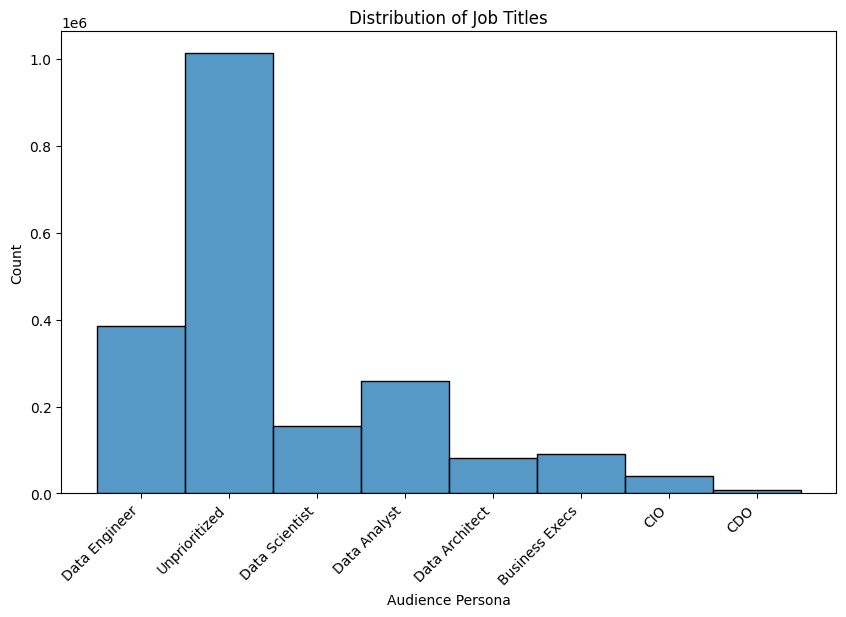

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['custom_audience_persona'], kde=False)
plt.title('Distribution of Job Titles')
plt.xlabel('Audience Persona')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


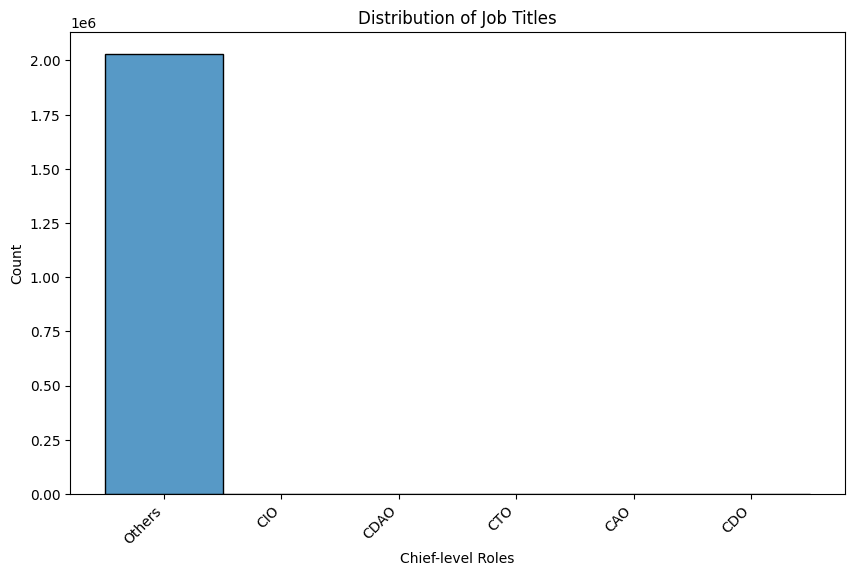

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['custom_cdo_cio_cto'], kde=False)
plt.title('Distribution of Job Titles')
plt.xlabel('Chief-level Roles')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


Initializing lemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()

Defining a function for text preprocessing

In [ ]:
def preprocess_text(text):
    # Checking if text is a string, convert to string if not
    if not isinstance(text, str):
        text = str(text)
    # Converting to lowercase
    text = text.lower()

    # Normalizing abbreviations (e.g., C.T.O. -> CTO)
    text = re.sub(r'\b(c\.t\.o|c t o)\b', 'cto', text)
    text = re.sub(r'\b(c\.i\.s\.o|c i s o)\b', 'ciso', text)

    # Removing special characters and punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Tokenizing the text
    tokens = text.split()

    # Removing stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]

    # Lemmatizing the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Joining tokens back into a single string
    text = ' '.join(tokens)

    return text

Applying preprocessing to the 'titles' column

In [ ]:
df['processed_title'] = df['title'].apply(preprocess_text)

Displaying the first few rows of the processed data

In [ ]:
print(df[['title', 'processed_title']].head())

                                               title  \
0                   VP Digital Transformation DevOps   
1                             Senior Patent Attorney   
2         Assistant Professor, School of Engineering   
3  Engineering Director, Software Products, Elect...   
4                 MS Data Science Graduating Student   

                                    processed_title  
0                  vp digital transformation devops  
1                            senior patent attorney  
2            assistant professor school engineering  
3  engineering director software product electrolux  
4                 m data science graduating student  


In [ ]:
print(df['custom_audience_persona'].isna().sum())
print(df['custom_cdo_cio_cto'].isna().sum())

0
0


Saving this processed file as 'processed_data1.csv' for Model I and 'processed_data2.csv' for Model II

In [ ]:
# Create the first dataset
df1 = df[['title', 'processed_title', 'custom_audience_persona']].copy()
df1.to_csv('processed_data1.csv', index=False)

# Create the second dataset
df2 = df[['title', 'processed_title', 'custom_cdo_cio_cto']].copy()
df2.to_csv('processed_data2.csv', index=False)
